In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

from transformers import AutoModel, AutoTokenizer

from tqdm import tqdm
import json

import torch.nn as nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import F1Score, Accuracy

import lightning as L
import random

from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

c:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("data/all_v2.json","r") as j_file:
    data = json.load(j_file)

In [3]:
def embed_descriptions(descriptions, model_directory, batch_size=32):
    """ Given a list of descriptions, a model directory, and a device, returns embeddings for the descriptions."""
    tokenizer = AutoTokenizer.from_pretrained(model_directory)

    # Load pre-trained model (weights)
    model = AutoModel.from_pretrained(model_directory)

    model.eval()  # Put the model in "evaluation" mode, which turns off dropout
    print(f"Model loaded | Generating embeddings with batch size={batch_size}")

    # Prepare inputs as a dictionary for the model
    inputs = tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt", max_length=64)
    inputs = {k: v for k, v in inputs.items()}  # Move inputs to the specified device

    # Process in batches with tqdm for progress tracking
    embeddings = []
    for i in tqdm(range(0, len(descriptions), batch_size), desc="Generating Embeddings"):
        batch = {k: v[i:i + batch_size] for k, v in inputs.items()}  # Create batch for the current iteration
        with torch.no_grad():
            outputs = model(**batch)

        # Extract pooled output embeddings
        batch_embeddings = outputs.pooler_output
        embeddings.append(batch_embeddings)

    # Concatenate batched embeddings
    embeddings = torch.cat(embeddings, dim=0)

    return {descriptions[i]: embeddings[i] for i in range(len(descriptions))}

In [4]:
# generate embeddings

# get set of all descriptions / reasondescriptions
texts = set()

for patient in tqdm(data):
    for encounter in patient["encounters"]:
        texts.add(encounter["encounter"]["Description"]) # append enc description
        texts.add(encounter["encounter"]["ReasonDescription"]) # append enc reasondescription

        texts = texts | set([_["Description"] for _ in encounter["conditions"]]) # condition desc

        texts = texts | set([_["Description"] for _ in encounter["careplans"]]) # careplan descs

        texts = texts | set([_["ReasonDescription"] for _ in encounter["careplans"]]) # careplan reas descs

        texts = texts | set([_["Description"] for _ in encounter["procedures"]]) # proc descs

        texts = texts | set([_["ReasonDescription"] for _ in encounter["procedures"]]) # proc reas descs

text2embeddings = embed_descriptions(list(texts), "BioLORD-2023")

  0%|          | 0/66331 [00:00<?, ?it/s]

100%|██████████| 66331/66331 [03:17<00:00, 336.48it/s]


Model loaded | Generating embeddings with batch size=32


Generating Embeddings: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


In [5]:
class PatientDataset(Dataset):
    def __init__(self, data, text2embedding):
        self.data = data
        self.text2embedding = text2embedding

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        patient = self.data[idx]
        embeddings = []

        for encounter in patient['encounters']:
            # Fetch embeddings for each text piece
            for key in ['Description', 'ReasonDescription']:
                text = encounter['encounter'].get(key, '')
                if text and text in self.text2embedding:
                    embeddings.append(self.text2embedding[text])

            for item_type in ['conditions', 'careplans', 'procedures']:
                for item in encounter[item_type]:
                    for key in ['Description', 'ReasonDescription']:
                        text = item.get(key, '')
                        if text and text in self.text2embedding:
                            embeddings.append(self.text2embedding[text])

        # Stack embeddings if not empty, else return a zero tensor
        embeddings_tensor = torch.stack(embeddings) if embeddings else torch.zeros(1, len(next(iter(self.text2embedding.values()))))

        return {
            'embeddings': embeddings_tensor,  # a list of tensors
            'features': torch.tensor([patient['lat'], patient['lon']]),
            'label': int(patient["label"])
        }

In [6]:
def collate_fn(batch):
    embeddings = [item['embeddings'] for item in batch]
    features = torch.stack([item['features'] for item in batch])
    labels = torch.tensor([int(item['label']) for item in batch])

    # Pad the embeddings sequences
    embeddings_padded = pad_sequence(embeddings, batch_first=True)

    return {
        'embeddings': embeddings_padded,
        'features': features,
        'label': labels
    }

In [7]:
class EncounterAutoencoder(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=128):
        super(EncounterAutoencoder, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        return hidden[-1]  # Taking the last hidden state as the representation

class PatientAutoencoder(L.LightningModule):
    def __init__(self, embedding_dim=768, hidden_dim=128, patient_latent_dim=64):
        super(PatientAutoencoder, self).__init__()
        self.encounter_autoencoder = EncounterAutoencoder(embedding_dim, hidden_dim)
        self.patient_encoder = nn.Linear(hidden_dim, patient_latent_dim)
        self.patient_decoder = nn.Linear(patient_latent_dim, hidden_dim)

        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()

        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

    def forward(self, x):

        encounter_representation = self.encounter_autoencoder(x['embeddings'])
        patient_encoded = self.patient_encoder(encounter_representation)
        patient_decoded = self.patient_decoder(patient_encoded)

        return patient_decoded
    
    def _common_step(self, batch, batch_idx, loss_metric, acc_metric, loss_lbl, metric_lbl):

        X = batch
        logits = self.forward(X)

        loss = loss_metric(logits, self.encounter_autoencoder(X["embeddings"]))

        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, acc_metric(logits, self.encounter_autoencoder(X["embeddings"])), prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_mse, self.train_mae, "train_mse", "train_mae")

    def on_training_epoch_end(self):
        self.log("train_mse", self.train_mse.compute())
        self.log("train_mae", self.train_mae.compute())
        self.train_mse.reset()
        self.train_mae.reset()

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mse, self.val_mae, "val_mse", "val_mae")

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_mse.compute())
        self.log("val_mae", self.val_mae.compute())
        self.val_mse.reset()
        self.val_mae.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mse, self.val_mae, "test_mse", "test_mae")

    def on_test_epoch_end(self):
        self.log("test_mse", self.test_mse.compute())
        self.log("test_mae", self.test_mae.compute())
        self.test_mse.reset()
        self.test_mae.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer


In [8]:
def split_list(input_list, split_ratios):
    total_length = len(input_list)
    assert sum(split_ratios) == 1.0, "Split ratios must sum up to 1.0"

    split_lengths = [int(total_length * ratio) for ratio in split_ratios]
    split_lengths[-1] += total_length - sum(split_lengths)  # Adjust last split length to handle rounding errors

    splits = []
    start_idx = 0
    for length in split_lengths:
        splits.append(input_list[start_idx:start_idx + length])
        start_idx += length

    return splits

In [9]:
split_ratios = [0.7, 0.15, 0.15]

random.shuffle(data)
train_data, val_data, test_data = split_list(data, split_ratios)

print(f"""
train: {len(train_data)}
  val: {len(val_data)}
 test: {len(test_data)}
""")


train: 46431
  val: 9949
 test: 9951



In [10]:
train_ds, val_ds, test_ds = PatientDataset(train_data, text2embeddings), PatientDataset(val_data, text2embeddings), PatientDataset(test_data, text2embeddings)
train_dl, val_dl, test_dl = DataLoader(train_ds, batch_size=10, shuffle=True, collate_fn=collate_fn), DataLoader(val_ds, batch_size=10, collate_fn=collate_fn), DataLoader(test_ds, batch_size=10, collate_fn=collate_fn)

# Initialize the model
embedding_dim = 768
hidden_dim = 128  # Intermediate representation size
patient_latent_dim = 64  # Final latent space dimension for the patient

model = PatientAutoencoder(embedding_dim, hidden_dim, patient_latent_dim)

logger = CSVLogger("pl_logs", name="hae")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(max_epochs=10, accelerator="cpu", callbacks=[
    ModelCheckpoint(
        monitor="train_mse", mode="min", save_last=True, save_top_k=1,
        dirpath="checkpoints/", filename="hae-{epoch:02d}-{val_mse:.2f}"
    ),
    EarlyStopping(monitor="train_mse", patience=3, mode="min")
], logger=logger)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: pl_logs\hae

  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | encounter_autoencoder | EncounterAutoencoder | 459 K 
1 | patient_encoder       | Linear               | 8.3 K 
2 | patient_decoder       | Linear               | 8.3 K 
3 | train_mse             | MeanSquaredError     | 0     
4 | val_mse               | MeanSquaredError     | 0     
5 | test_mse              | MeanSquaredError     | 0     
6 | train_mae             | MeanAbsoluteError    | 0     
7 | val_mae               | MeanAbsoluteError    | 0     
8 | test_mae              | MeanAbsoluteError    | 0     
---------------------------------------------------------------
476 K     Trainable params
0         Non-trainable params
476 K     Total params
1.905     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:  11%|█▏        | 529/4644 [16:44<2:10:17,  0.53it/s, v_num=0, train_mse=1.76e-6, train_mae=0.000683]

c:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\.venv\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


array([[<Axes: >, <Axes: >]], dtype=object)

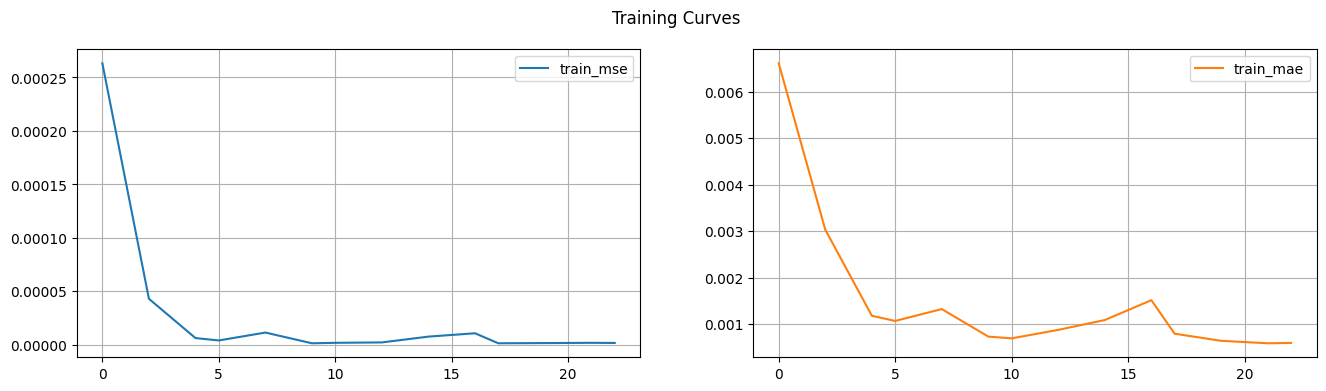

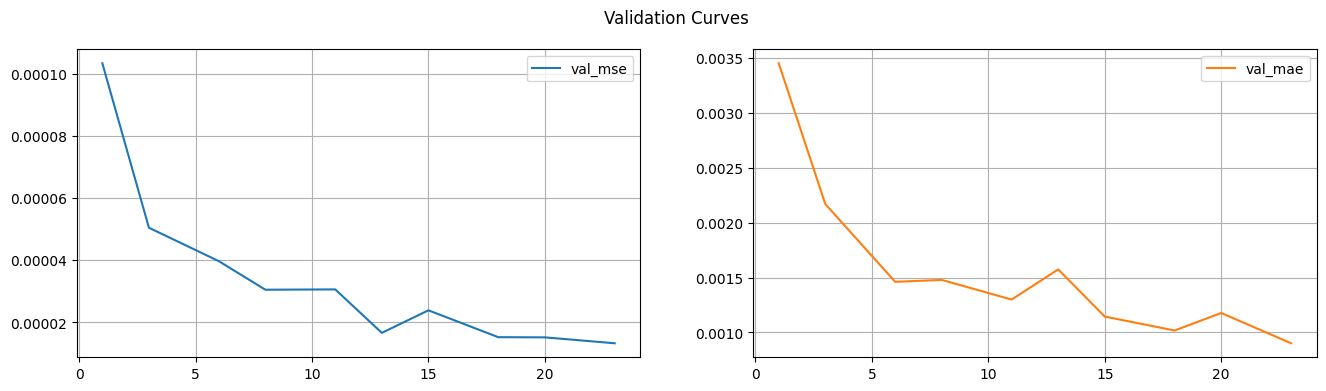

In [12]:
import os
import pandas as pd

hist = pd.read_csv(f"./pl_logs/hae/version_{len(os.listdir('./pl_logs/hae/')) - 1}/metrics.csv")
hist[['train_mse', 'train_mae']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_mse', 'val_mae']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [18]:
class PatientClassifier(L.LightningModule):
    def __init__(self, encoder, hidden_dim):
        super().__init__()
        num_classes = 2

        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(hidden_dim, num_classes)  # Two output neurons for binary classification

        self.val_acc = Accuracy(task="binary", num_classes=num_classes)
        self.test_acc = Accuracy(task="binary", num_classes=num_classes)
        self.train_acc = Accuracy(task="binary", num_classes=num_classes)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, x):
        encoded_features = self.encoder(x)
        logits = self.classifier(encoded_features)

        return logits

    def _common_step(self, batch, batch_idx, metric, loss_lbl, metric_lbl):
        x, y = batch["embeddings"], batch["label"]

        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss_function(logits, y)
        
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, metric(preds, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_acc, "train_loss", "train_acc")

    def on_training_epoch_end(self):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_acc, "val_loss", "val_acc")

    def on_validation_epoch_end(self):
        self.log("val_acc", self.val_acc.compute())
        self.val_acc.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_acc, "test_loss", "test_acc")

    def on_test_epoch_end(self):
        self.log("test_acc", self.test_acc.compute())
        self.test_acc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.classifier.parameters(), lr=0.001)
        return optimizer


In [19]:
embedding_dim = 768
hidden_dim = 128  # Intermediate representation size
patient_latent_dim = 64  # Final latent space dimension for the patient

pretrained_hae = PatientAutoencoder.load_from_checkpoint(checkpoint_path='checkpoints/last.ckpt')
encoder = nn.Sequential(
    pretrained_hae.encounter_autoencoder,
    pretrained_hae.patient_encoder
)

classifier_model = PatientClassifier(encoder=encoder, hidden_dim=patient_latent_dim)

train_ds, val_ds, test_ds = PatientDataset(train_data, text2embeddings), PatientDataset(val_data, text2embeddings), PatientDataset(test_data, text2embeddings)
train_dl, val_dl, test_dl = DataLoader(train_ds, batch_size=10, shuffle=True, collate_fn=collate_fn), DataLoader(val_ds, batch_size=10, collate_fn=collate_fn), DataLoader(test_ds, batch_size=10, collate_fn=collate_fn)

logger = CSVLogger("pl_logs", name="hae_classifier")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(max_epochs=10, accelerator="cpu", callbacks=[
    ModelCheckpoint(
        monitor="val_loss", mode="min", save_last=True, save_top_k=1,
        dirpath="checkpoints/", filename="hae_classifier-{epoch:02d}-{val_loss:.2f}"
    ),
    EarlyStopping(monitor="val_loss", patience=3, mode="min")
], logger=logger)
trainer.fit(classifier_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\.venv\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\checkpoints exists and is not empty.

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder       | Sequential       | 468 K 
1 | classifier    | Linear           | 130   
2 | val_acc       | BinaryAccuracy   | 0     
3 | test_acc      | BinaryAccuracy   | 0     
4 | train_acc     | BinaryAccuracy   | 0     
5 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
130       Trainable params
468 K     Non-trainable params
468 K     Total params
1.873     Total estimated model params size (M

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\kolton.hauck\Documents\Kolton's Cotiviti Vault\UofU\BMI6114_FinalProject\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 6: 100%|██████████| 70/70 [00:11<00:00,  6.36it/s, v_num=2, train_loss=0.361, train_acc=0.900, val_loss=0.548, val_acc=0.767]


In [21]:
trainer.test(classifier_model, dataloaders=test_dl)

Testing DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 15/15 [00:02<00:00,  7.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7266666889190674
        test_loss           0.6034016013145447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6034016013145447, 'test_acc': 0.7266666889190674}]